RNN model: Encoder-decoder LSTM RNN

In [1]:
import matplotlib.pyplot as plt
import scipy as sp
import sys
import pandas as pd
import numpy as np
import datetime,time
%matplotlib inline

In [2]:
from random import randint
from numpy import array
from numpy import argmax
from numpy import array_equal
from keras.utils import to_categorical
from keras.models import Model
from keras.layers import Input
from keras.layers import LSTM
from keras.layers import Dense

Using Theano backend.


In [3]:
from keras import Sequential

In [4]:
# import my package
sys.path.append(r"C:\Users\Fan\OneDrive - tongji.edu.cn\Project_in_UA\Fan' file\2_UA_Project\ProjectFenestration\2_Model\Control_Oriented_Model\Code\SourceCode")
from Data_Preprocessing import *

#### Global parameters

In [5]:
## Some Global Variables

## You need to specify these three parameters everytime!!!
TimeInterval = '10T' # 10 mins
PredictionHorizon = "6H"
time_lags = [1]

In [6]:
workingPath = r"C:\Users\Fan\OneDrive - tongji.edu.cn\Project_in_UA\Fan' file\2_UA_Project\ProjectFenestration\2_Model\Control_Oriented_Model\Data"

# January
workingPath_Jan = r"C:\Users\Fan\OneDrive - tongji.edu.cn\Project_in_UA\Fan' file\2_UA_Project\ProjectFenestration\2_Model\Control_Oriented_Model\Data\Jan_Case"

# July
workingPath_July = r"C:\Users\Fan\OneDrive - tongji.edu.cn\Project_in_UA\Fan' file\2_UA_Project\ProjectFenestration\2_Model\Control_Oriented_Model\Data\July_Case"

FileName = []
FileName.append("Cor_Month.csv")
FileName.append("Sou_Month.csv")
FileName.append("Nor_Month.csv")
FileName.append("Wes_Month.csv")
FileName.append("Eas_Month.csv")

<br id="Read_Data">

### read data
#### Initial Data

<br>
Read data from originald data file, which are not record in even time intervel

In [7]:
data = pd.read_csv(workingPath+"\\One_Month.csv")

##### Q: are all time interval smaller than 10s??

               data
count  40275.000000
mean      14.125909
std       23.397909
min        0.000000
25%        0.000000
50%        0.000000
75%       21.000000
max       60.000000


(60.0, False)

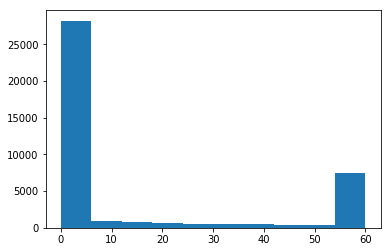

In [8]:
test_max_time_interval(data.iloc[:40276,0])

#### Read weather data

In [9]:
Weather_Data_resampled = read_WeatherData(workingPath+"\\WeatherData.csv")
Weather_Data_resampled.head()

,Dry Bulb Temperature {C},Dew Point Temperature {C},Relative Humidity {%},Atmospheric Pressure {Pa},Extraterrestrial Horizontal Radiation {Wh/m2},Extraterrestrial Direct Normal Radiation {Wh/m2},Horizontal Infrared Radiation Intensity from Sky {Wh/m2},Global Horizontal Radiation {Wh/m2},Direct Normal Radiation {Wh/m2},Diffuse Horizontal Radiation {Wh/m2}
Date,,,,,,,,,,
1970-01-01 00:00:00,-12.2,-16.1,73,99500,0,0,218,0,0,0
1970-01-01 00:00:10,-12.2,-16.1,73,99500,0,0,218,0,0,0
1970-01-01 00:00:20,-12.2,-16.1,73,99500,0,0,218,0,0,0
1970-01-01 00:00:30,-12.2,-16.1,73,99500,0,0,218,0,0,0
1970-01-01 00:00:40,-12.2,-16.1,73,99500,0,0,218,0,0,0


#### data preprocessing: transform the data into evenly sampled

In [10]:
Data_Jan= {}
Data_Jan['Cor'] = pd.read_csv(workingPath_Jan+"\\"+FileName[0],parse_dates =[0],
                              date_parser=lambda x:time.strftime("%Y-%m-%d %H:%M:%S",time.gmtime(float(x))),index_col=[0])
Data_Jan['Sou'] = pd.read_csv(workingPath_Jan+"\\"+FileName[1],parse_dates =[0],
                              date_parser=lambda x:time.strftime("%Y-%m-%d %H:%M:%S",time.gmtime(float(x))),index_col=[0])
Data_Jan['Nor'] = pd.read_csv(workingPath_Jan+"\\"+FileName[2],parse_dates =[0],
                              date_parser=lambda x:time.strftime("%Y-%m-%d %H:%M:%S",time.gmtime(float(x))),index_col=[0])
Data_Jan['Wes'] = pd.read_csv(workingPath_Jan+"\\"+FileName[3],parse_dates =[0],
                              date_parser=lambda x:time.strftime("%Y-%m-%d %H:%M:%S",time.gmtime(float(x))),index_col=[0])
Data_Jan['Eas'] = pd.read_csv(workingPath_Jan+"\\"+FileName[4],parse_dates =[0],
                              date_parser=lambda x:time.strftime("%Y-%m-%d %H:%M:%S",time.gmtime(float(x))),index_col=[0])

In [11]:
Data_Jan_Resampled = {}
for idx, value in Data_Jan.items():
    ## drop duplciates, and back fill nan
    Data_Jan_Resampled[idx] = value.drop_duplicates().bfill()
    Data_Jan_Resampled[idx] = Data_Jan[idx].iloc[0:1,:].append(Data_Jan[idx].iloc[1:,:].resample("10s",label ="right").mean()).bfill()  

In [12]:
## re_read data
data_with_Timestamps_resampled = read_Data(workingPath+"\\One_Month.csv")
data_with_Timestamps_resampled.head()

,TSupCor.T,flo.temAirPer5.T,VSupCor_flow.V_flow
Time,,,
1970-01-01 00:00:00,293.150,293.150,1.280000e-12
1970-01-01 00:00:10,293.189,293.151,1.148860e-03
1970-01-01 00:00:20,293.290,293.152,1.148240e-03
1970-01-01 00:00:30,293.357,293.153,1.148240e-03
1970-01-01 00:00:40,293.402,293.153,1.148230e-03


In [13]:
data_with_Timestamps_resampled = data_with_Timestamps_resampled.drop_duplicates().bfill()

data_with_Timestamps_resampled = data_with_Timestamps_resampled.iloc[0:1,:].append(data_with_Timestamps_resampled.iloc[1:,:].resample("10T",label ="right").mean()).bfill()  

In [14]:
data_with_Timestamps_resampled.head()

,TSupCor.T,flo.temAirPer5.T,VSupCor_flow.V_flow
Time,,,
1970-01-01 00:00:00,293.150000,293.150000,1.280000e-12
1970-01-01 00:10:00,294.827469,293.044281,1.147127e-03
1970-01-01 00:20:00,299.451500,292.677700,1.138635e-03
1970-01-01 00:30:00,302.780700,292.526000,1.130974e-03
1970-01-01 00:40:00,305.696636,292.438409,1.129829e-03


In [15]:
data_with_Timestamps_resampled.tail()

,TSupCor.T,flo.temAirPer5.T,VSupCor_flow.V_flow
Time,,,
1970-01-31 23:20:00,315.5110,295.3268,0.001024
1970-01-31 23:30:00,316.5482,295.2827,0.001197
1970-01-31 23:40:00,317.6777,295.2401,0.001718
1970-01-31 23:50:00,316.9375,295.1957,0.002532
1970-02-01 00:00:00,312.1834,295.1434,0.002805


In [16]:
data_with_Timestamps_resampled.shape

(4465, 3)

In [21]:
prediction_horizon_n = int(TimeInterval_Parser(PredictionHorizon)/TimeInterval_Parser(TimeInterval))
#time_lags = [1,36,72]
time_lags= [1,2,3]
lags = 144
#144
#[1,2,3,4,5,6,12,18,36,72,144]

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


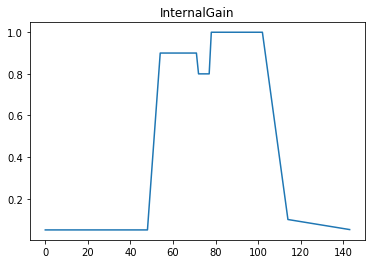

In [22]:
dataSetX_All,dataSetY_All = pre_Process(data_with_Timestamps_resampled,Weather_Data_resampled,TimeInterval,time_lags,prediction_horizon = prediction_horizon_n)

<br id ='Visualization'>

### Visualize the data before constructing models

In [16]:
from pandas.plotting import autocorrelation_plot

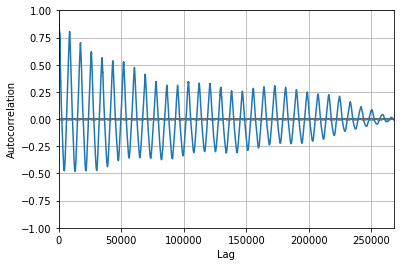

In [18]:
autocorrelation_plot(data_with_Timestamps_resampled.iloc[:,1])

<br id="Construct_ARX_models">

### construct RNN models 

```flow
 prepare data(normalize)--> training --> Model fitting 
```

Feature Generation
  * Category 1:
     * History data(Autoregressive term)
         1. t-1
     * Exogenous variables
     
| Items| Type  |
|:------:|------|
|1. Outdoor air temperature|numerical|
|2. Solar radiation|numerical|       
|3. Occupant| Categorical(binary)|
|4. Equipment|numerical|
|5. Lighting|numerical|
|6. Supply air temperature|numerical|
|7. Supply air flowrate    |numerical|

         

#### walk-forward model validation

In [17]:
from pandas import DataFrame
from pandas import concat

In [25]:
def timeseries_to_multi_step(X,step = 144):
    re = []
    for i in range(X.shape[1]):
        columns = np.transpose([X.iloc[:,i].shift(j+1).fillna(0) for j in range(step)])
        re.append(columns)
    re = np.swapaxes(np.swapaxes(np.array(re),0,2),0,1)
    return re

In [23]:
# transform to multi steps dataset
dataX = timeseries_to_multi_step(dataSetX_All[['TSupCor.T', 'VSupCor_flow.V_flow','InternalGain','Dry Bulb Temperature {C}','occup']],lags)
dataY = dataSetY_All

# truncate head and tail
dataX = dataX[144:-36]
dataX2 = np.reshape(np.array(dataY.iloc[143:-37,:-1]),(-1,36,1))
dataY = np.reshape(np.array(dataY.iloc[144:-36,:-1]),(-1,36,1))

In [479]:
#Each time step of the test dataset will be walked one at a time.

In [27]:
data_temp = timeseries_to_supervised(dataY[:,0,:],3)

dataX_temp = np.reshape(data_temp.iloc[3:,0:3].values,(-1,1,3))
dataY_temp = data_temp.iloc[3:,-1]

In [28]:
# Split the data into training/testing sets
## Ratio of training sets to testing set: **5:1**
dataSetX_Temp =  dataSetX_All.iloc[147:-36,:]
dataSetY_Temp =  dataSetY_All.iloc[147:-36,:]

ratio = 1/5
splitting_Point = int(len(dataSetX_Temp)*4/5)
dataSetX_train, dataSetX_test = dataSetX_Temp.iloc[:splitting_Point,:],dataSetX_Temp.iloc[splitting_Point:,:]

dataSetY_train, dataSetY_test = dataSetY_Temp.iloc[:splitting_Point,:],dataSetY_Temp.iloc[splitting_Point:,:]

In [29]:
yhat0 = dataY_temp.shift(1)
yhat0.iloc[0] = yhat0.iloc[1] 

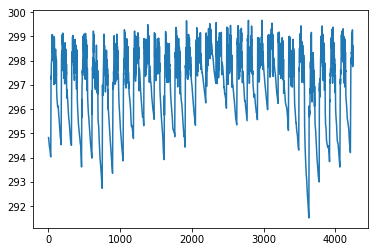

In [30]:
plt.plot(yhat0)

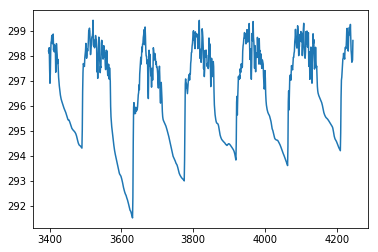

In [31]:
plt.plot(yhat0[-len(dataSetY_test):])

C:\ProgramData\Anaconda3\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


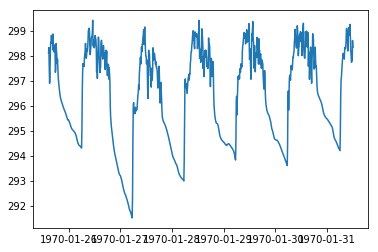

In [32]:
plt.plot(dataSetY_test.iloc[:,0])

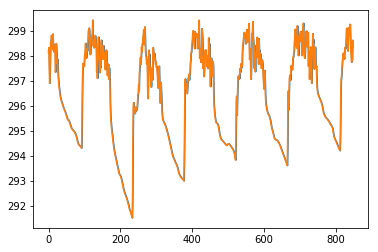

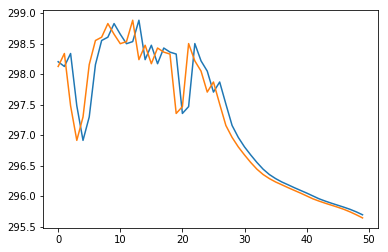

In [107]:
plt.plot(np.arange(len(dataSetY_test)),yhat0[-len(dataSetY_test):])
plt.plot(np.arange(len(dataSetY_test)),dataSetY_test.iloc[:,0])

plt.figure()
plt.plot(np.arange(50),yhat0[-len(dataSetY_test):-len(dataSetY_test)+50])
plt.plot(np.arange(50),dataSetY_test.iloc[:50,0])

#### Encoder-Decoder Model

In [46]:
# returns train, inference_encoder and inference_decoder models
def define_models(n_input, n_output, n_units):
    # define training encoder
    encoder_inputs = Input(shape=(None, n_input))
    encoder = LSTM(n_units, return_state=True)
    encoder_outputs, state_h, state_c = encoder(encoder_inputs)
    encoder_states = [state_h, state_c]
    # define training decoder
    decoder_inputs = Input(shape=(None, n_output))
    decoder_lstm = LSTM(n_units, return_sequences=True, return_state=True)
    decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)
    decoder_dense = Dense(n_output, activation='softmax')
    decoder_outputs = decoder_dense(decoder_outputs)
    model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
    # define inference encoder
    encoder_model = Model(encoder_inputs, encoder_states)
    # define inference decoder
    decoder_state_input_h = Input(shape=(n_units,))
    decoder_state_input_c = Input(shape=(n_units,))
    decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
    decoder_outputs, state_h, state_c = decoder_lstm(decoder_inputs, initial_state=decoder_states_inputs)
    decoder_states = [state_h, state_c]
    decoder_outputs = decoder_dense(decoder_outputs)
    decoder_model = Model([decoder_inputs] + decoder_states_inputs, [decoder_outputs] + decoder_states)
    # return all models
    return model, encoder_model, decoder_model

# generate target given source sequence
def predict_sequence(infenc, infdec, source, n_steps, cardinality):
    # encode
    state = infenc.predict(source)
    # start of sequence input
    target_seq = array([0.0 for _ in range(cardinality)]).reshape(1, 1, cardinality)
    # collect predictions
    output = list()
    for t in range(n_steps):
        # predict next char
        yhat, h, c = infdec.predict([target_seq] + state)
        # store prediction
        output.append(yhat[0,0,:])
        # update state
        state = [h, c]
        # update target sequence
        target_seq = yhat
    return array(output)

In [47]:
# generate a sequence of random integers
def generate_sequence(length, n_unique):
	return [randint(1, n_unique-1) for _ in range(length)]

# prepare data for the LSTM
def get_dataset(n_in, n_out, cardinality, n_samples):
	X1, X2, y = list(), list(), list()
	for _ in range(n_samples):
		# generate source sequence
		source = generate_sequence(n_in, cardinality)
		# define padded target sequence
		target = source[:n_out]
		target.reverse()
		# create padded input target sequence
		target_in = [0] + target[:-1]
		# encode
		src_encoded = to_categorical(source, num_classes=cardinality)
		tar_encoded = to_categorical(target, num_classes=cardinality)
		tar2_encoded = to_categorical(target_in, num_classes=cardinality)
		# store
		X1.append(src_encoded)
		X2.append(tar2_encoded)
		y.append(tar_encoded)
	return array(X1), array(X2), array(y)

# decode a one hot encoded string
def one_hot_decode(encoded_seq):
	return [argmax(vector) for vector in encoded_seq]

In [48]:
# generate training dataset
X1, X2, y = get_dataset(6, 3, 51, 100000)

In [49]:
y.shape

(100000, 3, 51)

In [50]:
# define model
train1, infenc1, infdec1 = define_models(51, 51,128)
train1.compile(optimizer = 'adam',loss='categorical_crossentropy')
train1.fit([X1,X2],y,epochs = 1)

Epoch 1/1
100000/100000 [==============================] - 37s 366us/step - loss: 0.6483


In [51]:
# configure problem
n_features = 5
n_out = 1
n_steps_in = lags
n_steps_out = prediction_horizon

# define model
train, infenc, infdec = define_models(n_features, n_out,128)
train.compile(optimizer = 'adam',loss='mse')

# split data into train set and test set
ratio = 1/5
splitPoint = int(len(dataX)/5*4)
dataX_train,dataX_test = dataX[:splitPoint],dataX[splitPoint:]
dataX2_train,dataX2_test = dataX2[:splitPoint],dataX2[splitPoint:]
dataY_train,dataY_test = dataY[:splitPoint],dataY[splitPoint:]


# train model
train.fit([dataX_train,dataX2_train],dataY_train,epochs = 10)

NameError: name 'prediction_horizon' is not defined

In [169]:
# Evaluate model
target = predict_sequence(infenc,infdec, np.array([dataX_test[0]]),n_steps_out,1)

In [171]:
target = predict_sequence(infenc,infdec, np.array([dataX_test[1]]),n_steps_out,1)

In [173]:
target = predict_sequence(infenc,infdec, np.array([dataX_test[2]]),n_steps_out,1)

In [472]:
target

array([[1.],
       [1.],
       [1.]], dtype=float32)

In [232]:
# configure problem
n_features = 51
n_steps_in = 6
n_steps_out = 3
# define model
train, infenc, infdec = define_models(1, 1, 128)
train.compile(optimizer='adam', loss='mse', metrics=['acc'])
# generate training dataset
X1, X2, y = get_dataset(n_steps_in, n_steps_out, n_features, 100000)
print(X1.shape,X2.shape,y.shape)

(100000, 6, 51) (100000, 3, 51) (100000, 3, 51)


In [233]:
X1_single = []
for x1 in X1:
    X1_single.append(one_hot_decode(x1))
X1_single = np.reshape(X1_single,(100000,6,1))
X2_single = []
for x2 in X2:
    X2_single.append(one_hot_decode(x2))
X2_single = np.reshape(X2_single,(100000,3,1))
y_single = []
for ydot in y:
    y_single.append(one_hot_decode(ydot))
y_single = np.reshape(y_single,(100000,3,1))

In [234]:
# train model
train.fit([X1_single, X2_single], y_single, epochs=1)

Epoch 1/1
100000/100000 [==============================] - 38s 378us/step - loss: 807.8126 - acc: 0.0200


In [237]:
[X1_single[0,:,:]]

[array([[37],
        [20],
        [ 2],
        [ 3],
        [22],
        [38]], dtype=int64)]

In [238]:
target = predict_sequence(infenc, infdec, np.reshape(X1_single[0,:,:],(1,6,1)), n_steps_out, 1)

In [239]:
target

array([[1.],
       [1.],
       [1.]], dtype=float32)

In [ ]:
# train model
train.fit([X1, X2], y, epochs=1)
# evaluate LSTM
total, correct = 100, 0
for _ in range(total):
	X1, X2, y = get_dataset(n_steps_in, n_steps_out, n_features, 1)
	target = predict_sequence(infenc, infdec, X1, n_steps_out, n_features)
	if array_equal(one_hot_decode(y[0]), one_hot_decode(target)):
		correct += 1
print('Accuracy: %.2f%%' % (float(correct)/float(total)*100.0))
# spot check some examples
for _ in range(10):
	X1, X2, y = get_dataset(n_steps_in, n_steps_out, n_features, 1)
	target = predict_sequence(infenc, infdec, X1, n_steps_out, n_features)
	print('X=%s y=%s, yhat=%s' % (one_hot_decode(X1[0]), one_hot_decode(y[0]), one_hot_decode(target)))

#### ARX model(auto-regressive model with External variable)

In [20]:
from statsmodels.tools import add_constant 

In [21]:
import statsmodels
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error, r2_score

In [22]:
from statsmodels.regression.linear_model import OLS

In [31]:
# Split the data into training/testing sets
## Ratio of training sets to testing set: **5:1**
dataSetX_Temp =  dataSetX_All.iloc[147:-36,:]
dataSetY_Temp =  dataSetY_All.iloc[147:-36,:]

ratio = 1/5
splitting_Point = int(len(dataSetX_Temp)*4/5)
dataSetX_train, dataSetX_test = dataSetX_Temp.iloc[:splitting_Point,:],dataSetX_Temp.iloc[splitting_Point:,:]

dataSetY_train, dataSetY_test = dataSetY_Temp.iloc[:splitting_Point,:],dataSetY_Temp.iloc[splitting_Point:,:]

In [428]:
dataSetX_Temp.shape

(4243, 18)

In [416]:
#define model
regr = OLS(dataSetY_train.iloc[:,0],dataSetX_train.iloc[:,:9])
result_Model = regr.fit()

In [417]:
yhat4 = result_Model.predict(dataSetX_test.iloc[:,:9])

In [418]:
yhat4.shape

(850,)

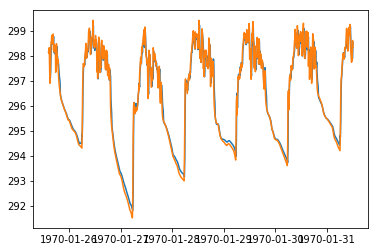

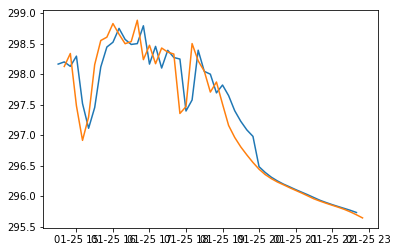

In [448]:
plt.plot(yhat4)
plt.plot(dataSetY_test.iloc[:,0])

plt.figure()
plt.plot(yhat4[:50])
plt.plot(dataSetY_test.iloc[:50,0])

#### MLP model
Still can be improved by
* shuffle vs No shuffle
* Normalization method
* Multiple layers
* feature engineering

In [84]:
n_steps = 1
n_features = 3
# define model
model = Sequential()

model.add(Dense(50, activation='relu',input_shape = (1,3)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

dataX_temp = np.reshape(data_temp.iloc[3:,0:3].values,(-1,1,3))
dataY_temp = np.reshape(data_temp.iloc[3:,-1].values, (-1,1,1))
# Split dataset into train set and test set,split ratio 4:1
splitting_Point = int(len(dataX_temp)*4/5)
dataX_temp_train,dataX_temp_test = dataX_temp[:splitting_Point],dataX_temp[splitting_Point:]
dataY_temp_train,dataY_temp_test = dataY_temp[:splitting_Point],dataY_temp[splitting_Point:]

In [52]:
dataY_temp_train.shape

(3394, 1, 1)

In [53]:
# fit model
model.fit(dataX_temp_train,dataY_temp_train, epochs=10, verbose=1)

Epoch 1/10
3394/3394 [==============================] - 0s 12us/step - loss: 280.8606
Epoch 2/10
3394/3394 [==============================] - 0s 11us/step - loss: 0.1791
Epoch 3/10
3394/3394 [==============================] - 0s 12us/step - loss: 0.1771
Epoch 4/10
3394/3394 [==============================] - 0s 9us/step - loss: 0.1758
Epoch 5/10
3394/3394 [==============================] - 0s 11us/step - loss: 0.1794
Epoch 6/10
3394/3394 [==============================] - 0s 10us/step - loss: 0.1783
Epoch 7/10
3394/3394 [==============================] - 0s 11us/step - loss: 0.1773
Epoch 8/10
3394/3394 [==============================] - 0s 10us/step - loss: 0.1797
Epoch 9/10
3394/3394 [==============================] - 0s 11us/step - loss: 0.1776
Epoch 10/10
3394/3394 [==============================] - 0s 9us/step - loss: 0.1789


In [55]:
# demonstrate prediction
yhat2 = model.predict(dataX_temp_test, verbose=0)

In [58]:
yhat2

array([[[297.9494 ]],

       [[297.98026]],

       [[298.02606]],

       [[297.81912]],

       [[297.35352]],

       [[297.00604]],

       [[297.2734 ]],

       [[297.85214]],

       [[298.26907]],

       [[298.47214]],

       [[298.52213]],

       [[298.4651 ]],

       [[298.36444]],

       [[298.4456 ]],

       [[298.39236]],

       [[298.3043 ]],

       [[298.12302]],

       [[298.14816]],

       [[298.14603]],

       [[298.1809 ]],

       [[297.84158]],

       [[297.47507]],

       [[297.57434]],

       [[297.9332 ]],

       [[298.05505]],

       [[297.79935]],

       [[297.66574]],

       [[297.52194]],

       [[297.3113 ]],

       [[297.00662]],

       [[296.78006]],

       [[296.62067]],

       [[296.4849 ]],

       [[296.36343]],

       [[296.25687]],

       [[296.16974]],

       [[296.10092]],

       [[296.0455 ]],

       [[295.99655]],

       [[295.9506 ]],

       [[295.90546]],

       [[295.8603 ]],

       [[295.81406]],

       [[29

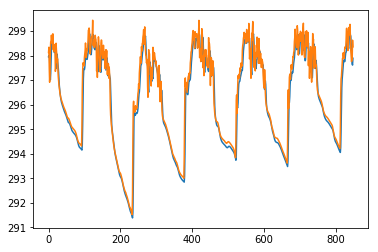

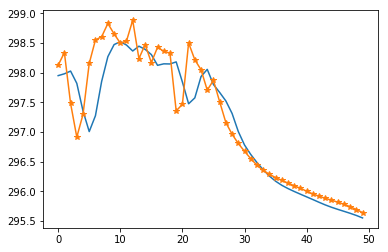

In [63]:
plt.plot(yhat2[:,0,0])
plt.plot(np.arange(len(dataY_temp_test)),dataY_temp_test[:,0,0])

plt.figure()
l = 50
plt.plot(np.arange(l),yhat2[:l,0,0])
plt.plot(np.arange(50),dataY_temp_test[:l,0,0],'-*')

#### Simple LSTM model

In [25]:
from pandas import DataFrame
from pandas import concat

##### Univariate but treated as Multi-variates

In [30]:
n_steps = 1
n_features = 3
# define model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(n_steps, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

dataX_temp = np.reshape(data_temp.iloc[3:,0:3].values,(-1,1,3))
dataY_temp = data_temp.iloc[3:,-1]
# Split dataset into train set and test set,split ratio 4:1
splitting_Point = int(len(dataX_temp)*4/5)
dataX_temp_train,dataX_temp_test = dataX_temp[:splitting_Point],dataX_temp[splitting_Point:]
dataY_temp_train,dataY_temp_test = dataY_temp[:splitting_Point],dataY_temp[splitting_Point:]

# fit model
model.fit(dataX_temp_train, dataY_temp_train, epochs=10, verbose=1)

NameError: name 'data_temp' is not defined

In [458]:
# demonstrate prediction
yhat2 = model2.predict(dataX_temp_test, verbose=0)

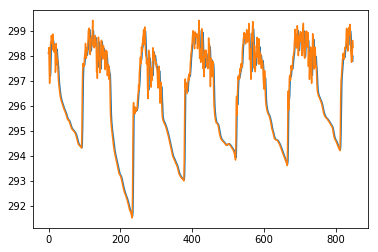

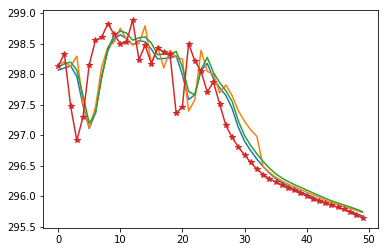

In [459]:
plt.plot(yhat2)
plt.plot(np.arange(len(dataY_temp_test)),dataY_temp_test)

plt.figure()
l = 50
plt.plot(yhat[:l])
plt.plot(np.arange(l),yhat4[:l])
plt.plot(np.arange(l),yhat2[:l])
plt.plot(np.arange(50),dataY_temp_test[:l],'-*')

##### Multi-steps

In [26]:
# frame a sequence as a supervised learning problem
def timeseries_to_supervised(data, lag=1):
    df = DataFrame(data)
    columns = [df.shift(i) for i in range(1, lag+1)]
    columns.append(df)
    df = concat(columns, axis=1)
    df.fillna(0, inplace=True)
    return df

In [59]:
data_temp = timeseries_to_supervised(DataFrame(scaler.fit_transform(dataY[:,0,:])),3)

In [60]:
data_temp.shape

(4246, 4)

In [38]:
n_steps = 3
n_features = 1
# define model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(n_steps, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

dataX_temp = np.reshape(data_temp.iloc[3:,0:3].values,(-1,3,1))
dataY_temp = data_temp.iloc[3:,-1]

In [ ]:
# Split dataset into train set and test set,split ratio 4:1
splitting_Point = int(len(dataX_temp)*4/5)
dataX_temp_train,dataX_temp_test = dataX_temp[:splitting_Point],dataX_temp[splitting_Point:]
dataY_temp_train,dataY_temp_test = dataY_temp[:splitting_Point],dataY_temp[splitting_Point:]

# fit model
model.fit(dataX_temp_train, dataY_temp_train, epochs=10, verbose=1)

In [441]:
# demonstrate prediction
yhat = model.predict(dataX_temp_test, verbose=0)

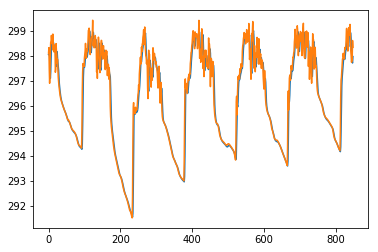

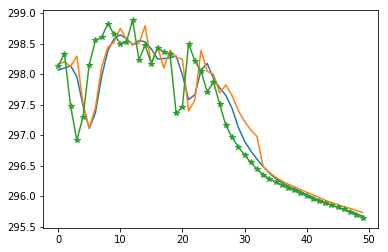

In [455]:
plt.plot(yhat)
plt.plot(np.arange(len(dataY_temp_test)),dataY_temp_test)

plt.figure()
l = 50
plt.plot(yhat[:l])
plt.plot(np.arange(l),yhat4[:l])
plt.plot(np.arange(50),dataY_temp_test[:l],'-*')

##### Multi-variate

In [39]:
### transform to multi steps dataset
dataX_temp2 = timeseries_to_multi_step(dataSetX_All[['TSupCor.T', 'VSupCor_flow.V_flow','InternalGain','Dry Bulb Temperature {C}','occup']],3)

# truncate head and tail
dataX_temp2 = dataX_temp2[147:-36]
dataY_temp2 = dataSetY_All.iloc[147:-36,0:1]

dataX_temp2 = np.concatenate((dataX_temp2,dataX_temp),axis=2)

In [42]:
# Split dataset into train set and test set,split ratio 4:1
splitting_Point = int(len(dataX_temp)*4/5)
dataX_temp_train,dataX_temp_test = dataX_temp2[:splitting_Point],dataX_temp2[splitting_Point:]
dataY_temp_train,dataY_temp_test = dataY_temp[:splitting_Point],dataY_temp[splitting_Point:]

In [43]:
n_steps = 3
n_features = 6
# define model
model3 = Sequential()
model3.add(LSTM(50, activation='relu', input_shape=(n_steps, n_features)))
model3.add(Dense(1))
model3.compile(optimizer='adam', loss='mse')

In [44]:
# fit model
model3.fit(dataX_temp_train, dataY_temp_train , epochs=50, verbose=1)

Epoch 1/50
3394/3394 [==============================] - 0s 121us/step - loss: 4186.7533
Epoch 2/50
3394/3394 [==============================] - 0s 59us/step - loss: 26.4665
Epoch 3/50
3394/3394 [==============================] - 0s 59us/step - loss: 19.2595
Epoch 4/50
3394/3394 [==============================] - 0s 61us/step - loss: 14.0745
Epoch 5/50
3394/3394 [==============================] - 0s 60us/step - loss: 11.0106
Epoch 6/50
3394/3394 [==============================] - 0s 66us/step - loss: 8.6397
Epoch 7/50
3394/3394 [==============================] - 0s 59us/step - loss: 7.0182
Epoch 8/50
3394/3394 [==============================] - 0s 61us/step - loss: 5.8116
Epoch 9/50
3394/3394 [==============================] - 0s 66us/step - loss: 4.9298
Epoch 10/50
3394/3394 [==============================] - 0s 59us/step - loss: 4.2808
Epoch 11/50
3394/3394 [==============================] - 0s 61us/step - loss: 3.8511
Epoch 12/50
3394/3394 [==============================] - 0s 69us/s

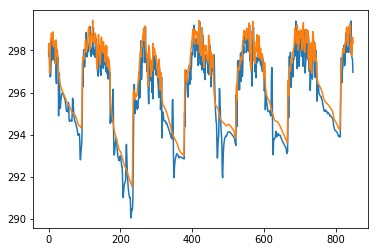

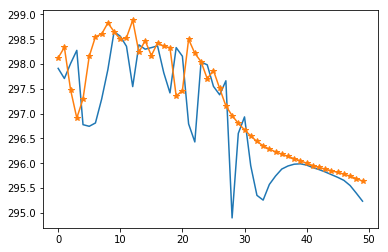

In [45]:
# demonstrate prediction
x_input = dataX_temp_test 
yhat3 = model3.predict(x_input, verbose=0)

plt.plot(yhat3)
plt.plot(np.arange(len(dataY_temp_test)),dataY_temp_test)

plt.figure()
l = 50
plt.plot(np.arange(l),yhat3[:l])
plt.plot(np.arange(50),dataY_temp_test[:l],'-*')

##### Multi-variate(scaled)

In [33]:
from sklearn.preprocessing import MinMaxScaler

In [ ]:
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))

In [65]:
### transform to multi steps dataset
temp = scaler.fit_transform(dataSetX_All[['TSupCor.T', 'VSupCor_flow.V_flow','InternalGain','Dry Bulb Temperature {C}','occup']])
dataX_temp2 = timeseries_to_multi_step(DataFrame(temp),3)

# truncate head and tail
dataX_temp2 = dataX_temp2[147:-36]
dataY_temp2 = dataSetY_All.iloc[147:-36,0:1]

dataX_temp2 = np.concatenate((dataX_temp2,dataX_temp),axis=2)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:334: DataConversionWarning: Data with input dtype int32, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [66]:
# Split dataset into train set and test set,split ratio 4:1
splitting_Point = int(len(dataX_temp)*4/5)
dataX_temp_train,dataX_temp_test = dataX_temp2[:splitting_Point],dataX_temp2[splitting_Point:]
dataY_temp_train,dataY_temp_test = dataY_temp[:splitting_Point],dataY_temp[splitting_Point:]

In [67]:
dataX_temp2.shape

(4243, 3, 6)

In [68]:
n_steps = 3
n_features = 6
# define model
model3 = Sequential()
model3.add(LSTM(50, activation='relu', input_shape=(n_steps, n_features)))
model3.add(Dense(1))
model3.compile(optimizer='adam', loss='mse')

In [69]:
# fit model
model3.fit(dataX_temp_train, dataY_temp_train , epochs=50, verbose=1)

Epoch 1/50
3394/3394 [==============================] - 0s 101us/step - loss: 0.0991
Epoch 2/50
3394/3394 [==============================] - 0s 73us/step - loss: 0.0045
Epoch 3/50
3394/3394 [==============================] - 0s 74us/step - loss: 0.0035
Epoch 4/50
3394/3394 [==============================] - 0s 76us/step - loss: 0.0027
Epoch 5/50
3394/3394 [==============================] - 0s 66us/step - loss: 0.0023
Epoch 6/50
3394/3394 [==============================] - 0s 79us/step - loss: 0.0020
Epoch 7/50
3394/3394 [==============================] - 0s 71us/step - loss: 0.0019
Epoch 8/50
3394/3394 [==============================] - 0s 102us/step - loss: 0.0018
Epoch 9/50
3394/3394 [==============================] - 0s 88us/step - loss: 0.0017
Epoch 10/50
3394/3394 [==============================] - 0s 101us/step - loss: 0.0017
Epoch 11/50
3394/3394 [==============================] - 0s 81us/step - loss: 0.0016
Epoch 12/50
3394/3394 [==============================] - 0s 87us/step -

In [70]:
# demonstrate prediction
x_input = dataX_temp_test 
yhat3 = model3.predict(x_input, verbose=0)

plt.plot(yhat3)
plt.plot(np.arange(len(dataY_temp_test)),dataY_temp_test)

plt.figure()
l = 50
plt.plot(np.arange(l),yhat3[:l])
plt.plot(np.arange(50),dataY_temp_test[:l],'-*')

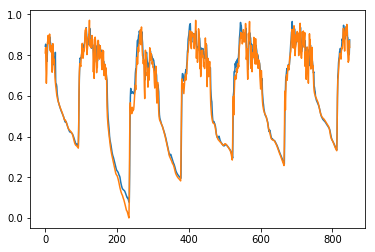

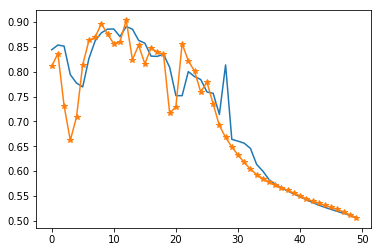

In [74]:
plt.plot(yhat3)
plt.plot(np.arange(len(dataY_temp_test)),dataY_temp_test)

plt.figure()
l = 50
plt.plot(np.arange(l),yhat3[:l])
plt.plot(np.arange(50),dataY_temp_test[:l],'-*')

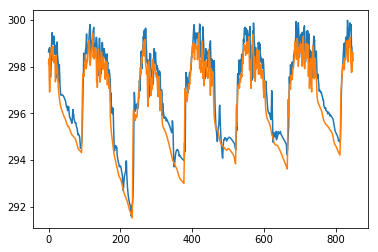

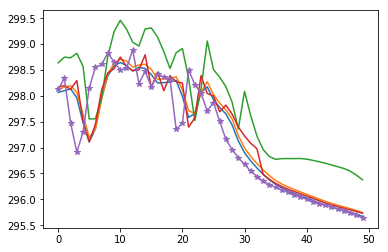

In [471]:
plt.plot(yhat3)
plt.plot(np.arange(len(dataY_temp_test)),dataY_temp_test)

plt.figure()
l = 50
plt.plot(yhat[:l])
plt.plot(np.arange(l),yhat2[:l])
plt.plot(np.arange(l),yhat3[:l])
plt.plot(np.arange(l),yhat4[:l])

plt.plot(np.arange(50),dataY_temp_test[:l],'-*')

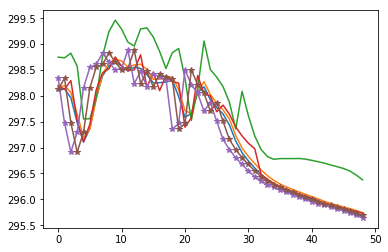

In [478]:
plt.figure()
l = 50
plt.plot(yhat[1:l])
plt.plot(np.arange(l-1),yhat2[1:l])
plt.plot(np.arange(l-1),yhat3[1:l])
plt.plot(np.arange(l-1),yhat4[1:l])

plt.plot(np.arange(49),dataY_temp_test[1:l],'-*')
plt.plot(np.arange(49),dataY_temp_test[:l-1],'-*')

In [481]:
from sklearn.metrics import mean_squared_error as mse

In [487]:
print('mse for Univariate LSTM is %.2f'%mse(yhat[1:l],dataY_temp_test[1:l]))
print('mse for Multi-step LSTM is %.2f'%mse(yhat2[1:l],dataY_temp_test[1:l]))
print('mse for Multi-step Multi-variate LSTM is %.2f'%mse(yhat3[1:l],dataY_temp_test[1:l]))
print('mse for ARX is %.2f'%mse(yhat4[1:l],dataY_temp_test[1:l]))
print('mse for MLP is %.2f'%mse(yhat4[1:l],dataY_temp_test[1:l]))

mse for Univariate LSTM is 0.17
mse for Multi-step LSTM is 0.20
mse for Multi-step Multi-variate LSTM is 0.75
mse for ARX is 0.23
mse for MLP is 0.23
